In [1]:
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
def european_call_simulation(S0, K, r, sigma, T, N, M):
    dt = T / N  # Time step size
    # Simulate paths
    S = np.zeros((M, N + 1))
    S[:, 0] = S0  # Initial price
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)  # Random numbers
        S[:, t] = S[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    # Calculate the payoff at maturity
    payoff = np.maximum(S[:, -1] - K, 0)
    
    # Discount back to present value
    option_price = np.exp(-r * T) * np.mean(payoff)
    
    return option_price

In [3]:
def american_put_simulation(S0, K, r, sigma, T, N, M):
    
    # Simulate Geometric Brownian Motion
    dt = T / N
    discount = np.exp(-r * dt)

    S = np.zeros((M, N + 1))
    S[:, 0] = S0
    for t in range(1, N + 1):
        Z = np.random.standard_normal(M)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Initialize cash flows at maturity
    cash_flows = np.maximum(K - S[:, -1], 0)  # Payoff at maturity

    # Least Squares Monte Carlo (LSMC) Method
    for t in range(N - 1, 0, -1):
        in_the_money = S[:, t] < K
        if np.any(in_the_money):
            # Regression to estimate continuation value
            x = S[in_the_money, t]
            y = cash_flows[in_the_money] * discount
            A = np.vstack([np.ones_like(x), x, x**2]).T
            coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
            continuation_value = coeffs[0] + coeffs[1] * x + coeffs[2] * x**2

            # Compare continuation value with immediate exercise value
            exercise_value = K - x
            exercise = exercise_value > continuation_value

            # Update cash flows for exercised paths
            cash_flows[in_the_money] = np.where(exercise, exercise_value, cash_flows[in_the_money] * discount)
        else:
            # Discount non-exercised paths
            cash_flows *= discount

    # Discount to time 0 to get the option price
    return np.mean(cash_flows) * np.exp(-r * dt)

In [13]:
K = 100.0
r = 0.05
sigma = 0.1
T = [0.0, 1.0]
N = 100
S = [80.0, 160.0]
M = 10000

# Create a grid of S and t values
S_grid = np.linspace(S[0], S[1], N)
t_grid = np.linspace(T[0], T[1], N)
S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)

# Calculate option prices for each (S, t) pair
put_prices = np.zeros_like(S_mesh)
for i, S in tqdm(enumerate(S_grid), total=len(S_grid)):
    for j, t in enumerate(t_grid):
        # Adjust the number of steps for truncated time periods
        truncated_steps = int((T[1] - t) / (T[1] / N))
        if truncated_steps > 0:
            put_prices[j, i] = american_put_simulation(S, K, T[1] - t, r, sigma, M, truncated_steps)

# Save the prices array
np.save('simulations/monte_carlo_american_put.npy', put_prices)

  0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
put_prices.shape

(100, 101)

In [ ]:
K = 100.0
r = 0.05
sigma = 0.1
T = [0.0, 1.0]
N = 100
S = [80.0, 160.0]
M = 100000

prices = []

for s in tqdm(np.linspace(S[0], S[1], N)):
    price_at_s = []
    for n, t in enumerate(np.linspace(T[1], T[0], N)):
        price_at_s.append(european_call_simulation(s, K, r, sigma, t, N-n, M))
    
    prices.append(price_at_s)

In [ ]:
prices = np.array(prices)

In [3]:
prices = np.load('simulations/monte_carlo_european_call.npy')

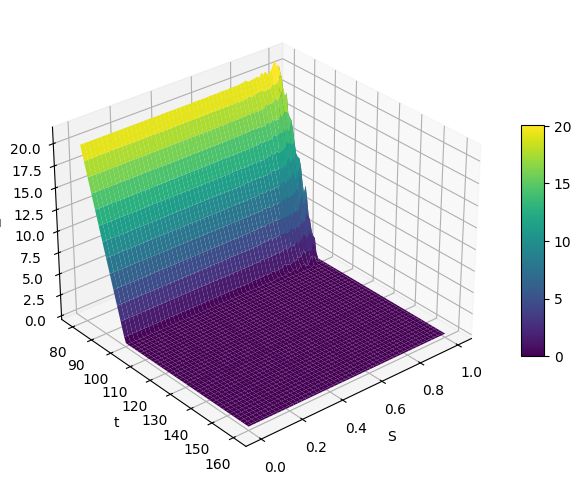

In [35]:
T = [0.0, 1.0]
N = 100
S = [80.0, 160.0]
 
s_grid = np.linspace(S[0], S[1], N)
t_grid = np.linspace(T[0], T[1], N)
# s_grid_mesh, t_grid_mesh = np.meshgrid(s_grid, t_grid)

fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d', elev=30, azim=130)
ax = plt.axes(projection='3d', elev=30, azim=230)
T_grid, S_plot = np.meshgrid(s_grid, t_grid)
surf = ax.plot_surface(S_plot, T_grid, put_prices, cmap='viridis', edgecolor='none')
# cbaxes = fig.add_axes([0.15, 0.3, 0.03, 0.4])
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.invert_yaxis()

ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.savefig('paper_plots/american_solution.png')
plt.show()

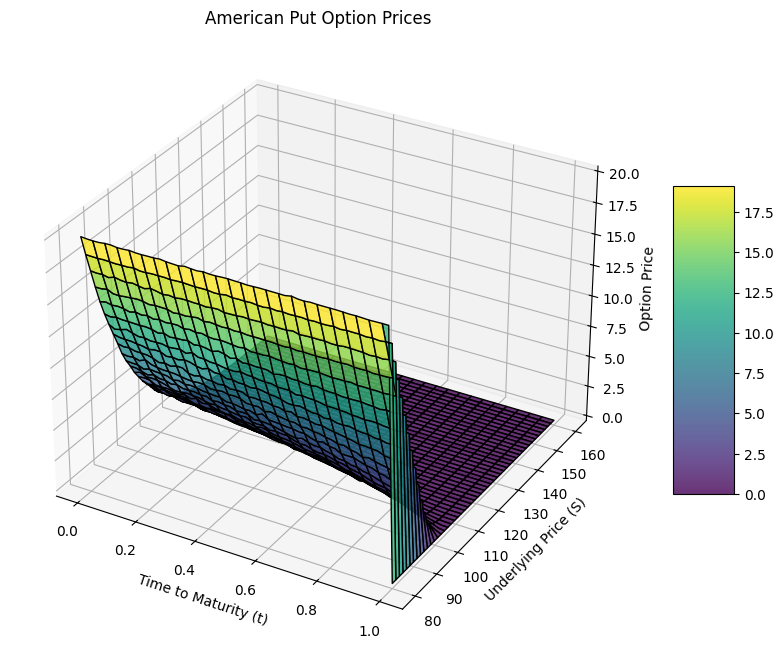

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
K = 100          # Strike price
T = 1.0          # Time to maturity (in years)
r = 0.05         # Risk-free rate
sigma = 0.2      # Volatility
n_paths = 10000  # Number of Monte Carlo paths
n_steps = 50     # Number of time steps
S_range = np.linspace(80, 160, 50)  # Range of stock prices

# Time increment
dt = T / n_steps
discount = np.exp(-r * dt)

# Function to price an American put using Monte Carlo and LSMC
def price_american_put(S0, K, T, r, sigma, n_paths, n_steps):
    # Simulate Geometric Brownian Motion
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        Z = np.random.standard_normal(n_paths)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    # Initialize cash flows at maturity
    cash_flows = np.maximum(K - S[:, -1], 0)  # Payoff at maturity

    # Least Squares Monte Carlo (LSMC) Method
    for t in range(n_steps - 1, 0, -1):
        in_the_money = S[:, t] < K
        if np.any(in_the_money):
            # Regression to estimate continuation value
            x = S[in_the_money, t]
            y = cash_flows[in_the_money] * discount
            A = np.vstack([np.ones_like(x), x, x**2]).T
            coeffs = np.linalg.lstsq(A, y, rcond=None)[0]
            continuation_value = coeffs[0] + coeffs[1] * x + coeffs[2] * x**2

            # Compare continuation value with immediate exercise value
            exercise_value = K - x
            exercise = exercise_value > continuation_value

            # Update cash flows for exercised paths
            cash_flows[in_the_money] = np.where(exercise, exercise_value, cash_flows[in_the_money] * discount)
        else:
            # Discount non-exercised paths
            cash_flows *= discount

    # Discount to time 0 to get the option price
    return np.mean(cash_flows) * np.exp(-r * dt)

# Create a grid of S and t values
S_grid = S_range
t_grid = np.linspace(0, T, n_steps + 1)
S_mesh, t_mesh = np.meshgrid(S_grid, t_grid)

# Calculate option prices for each (S, t) pair
option_prices = np.zeros_like(S_mesh)
for i, S in enumerate(S_grid):
    for j, t in enumerate(t_grid):
        # Adjust the number of steps for truncated time periods
        truncated_steps = int((T - t) / dt)
        if truncated_steps > 0:
            option_prices[j, i] = price_american_put(S, K, T - t, r, sigma, n_paths, truncated_steps)

# Plot the results
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(t_mesh, S_mesh, option_prices, cmap='viridis', edgecolor='k', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Labels and title
ax.set_xlabel('Time to Maturity (t)')
ax.set_ylabel('Underlying Price (S)')
ax.set_zlabel('Option Price')
plt.title('American Put Option Prices')
plt.show()
